In [1]:
using PyCall, PyPlot, ANTSUNData, HDF5, Statistics, CePNEMAnalysis, EncoderModelGen, FlavellBase,
    StatsBase, ImageFiltering, Optim, AnalysisBase, ProgressMeter, HypothesisTests, DSP

WebIO._IJuliaInit()

In [2]:
zstd = FlavellBase.standardize

standardize (generic function with 1 method)

In [3]:
path_fig_root = "/data1/prj_kfc/figure/manuscript/cell_draft2/ewma_analysis/"

"/data1/prj_kfc/figure/manuscript/cell_draft2/ewma_analysis/"

In [4]:
rc_params = PyDict(pyimport("matplotlib")["rcParams"]);
rc_params["font.sans-serif"] = ["Arial"];
rc_params["font.size"] = 7;
fix_plot() = (margins(0.05); tick_params(direction = "out"); ax = gca(); ax[:xaxis][:tick_bottom](); ax[:yaxis][:tick_left](); ax[:spines]["top"]["set_visible"](false); ax[:spines]["right"]["set_visible"](false););
fix_plot(ax) = (margins(0.05); tick_params(direction = "out"); ax[:xaxis][:tick_bottom](); ax[:yaxis][:tick_left](); ax[:spines]["top"]["set_visible"](false); ax[:spines]["right"]["set_visible"](false););

In [5]:
path_h5_enc = "/scratch/prj_kfc/2022-10-14-baseline-enc.h5"
datasets_baseline_merged = ["2021-05-26-07", "2021-06-11-01", "2021-08-04-06", "2021-08-17-01", "2021-08-18-01", "2021-09-22-05", "2021-10-26-01", "2021-11-12-01", "2021-11-12-05", "2022-01-09-01"]
datasets_baseline_1600 = ["2022-01-17-01", "2022-04-05-01", "2022-04-12-04", "2022-04-14-04"];
list_uid = sort(vcat(datasets_baseline_merged, datasets_baseline_1600))

list_dict_fit = h5read.(path_h5_enc, list_uid);
list_data_dict = []
for (idx_uid, data_uid) = enumerate(list_uid)
    path_data = "/scratch/prj_kfc/processed_h5/$(data_uid)-data.h5"
    data_dict = import_data(path_data)

    push!(list_data_dict, data_dict)
end

In [6]:
list_idx_neuron_use = Vector{Int}[]
for idx_uid = 1:length(list_uid)
    rng = 1
    dict_fit = list_dict_fit[idx_uid]
    timestep = dict_fit["timestep"]
    list_idx_neuron = unique(vcat([dict_fit["categorization"]["$rg_t"]["all"] for rg_t = 1:2]...))

    list_ = Int[]
    for idx_neuron = list_idx_neuron
        s0 = median(dict_fit["ps"][rng, idx_neuron, :, 7])
        s = compute_s(s0)
        τ = log.(s ./ (s .+ 1), 0.5) .* timestep

        if τ >= 15
            push!(list_, idx_neuron)
        end
    end

    push!(list_idx_neuron_use, list_)
end

s0: 1.6336901918131206
cost ewma: 0.5328733680503768
cost shift: 1.1700184462067493
cost gaussian: 0.9647953680887962
cost lp: 1.0126987486183656


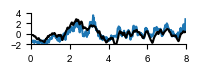

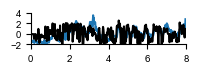

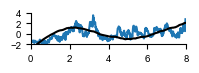

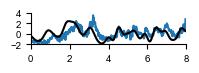

In [7]:
let
    data_uid = "2021-05-26-07"
    path_data = "/data1/jungsoo/data/processed_h5/$(data_uid)-data.h5"
    data_dict =  import_data(path_data)
    dict_fit = h5read(path_h5_enc, data_uid);

    trace_array = data_dict["trace_array"]
    
    
    
    # for idx_neuron = [102,94,7]
    idx_neuron = 7
    
    trace = trace_array[idx_neuron,:]
    v = data_dict["velocity"]
    
    rng = 1
    plt_rng=51:800    
    s0 = median(dict_fit["ps"][rng, idx_neuron, :, 7])
    s = compute_s(s0)
    timestep = dict_fit["timestep"] / 60
    x_rng = (plt_rng .- plt_rng[1]).*timestep

    println("s0: $s0")
    
    # ewma
    τ = log.(s ./ (s .+ 1), 0.5) .* dict_fit["timestep"]

    v_ewma = zstd(model_nl8(1600, 0., 1., 0., 0., 0., 0., s0, 0., data_dict["velocity"], zeros(1600), zeros(1600)))

    figure(figsize=(2,0.75))
    # title("ewma")
    plot(x_rng, trace_array[idx_neuron,plt_rng] |> zstd)
    plot(x_rng, v_ewma[plt_rng] |> zstd, color="k")
    ylim(-2,4)
    yticks(-2:2:4)
    xlim(0,8)
    fix_plot()
    tight_layout()
    savefig(joinpath(path_fig_root, "smoothing_ewma.pdf"))

    cost_ewma = cost_mse(trace_array[idx_neuron,plt_rng] |> zstd, v_ewma[plt_rng] |> zstd)
    println("cost ewma: $cost_ewma")
    
    # shift
    rg_xcor = -200:200
    xcorres = crosscor(data_dict["velocity"], trace_array[idx_neuron, :], rg_xcor)
    
    shift = rg_xcor[argmax(abs.(xcorres))]
    figure(figsize=(2,0.75))
    # title("optimal shift (cross correlation)")
    plot(x_rng, trace_array[idx_neuron,plt_rng] |> zstd)
    plot(x_rng, circshift(data_dict["velocity"][plt_rng], 2) |> zstd, color="k")
    ylim(-2,4)
    xlim(0,8)
    yticks(-2:2:4)
    fix_plot()
    tight_layout()
    savefig(joinpath(path_fig_root, "smoothing_xcor.pdf"))

    cost_shift = cost_mse(trace[plt_rng] |> zstd, circshift(data_dict["velocity"][plt_rng], shift) |>zstd)
    println("cost shift: $cost_shift")

    # gaussian smoothing
    
    cost_gaussian(x) = cost_mse(trace |> zstd, imfilter(v, ImageFiltering.Kernel.gaussian((x[1],))) |> zstd)

    opt_res = optimize(cost_gaussian, [3.])
    gaussian_min = opt_res.minimizer
    
    v_gaussian = imfilter(v, ImageFiltering.Kernel.gaussian((gaussian_min[1],)))
    figure(figsize=(2,0.75))
    # title("optimal guassian")
    plot(x_rng, trace[plt_rng] |> zstd)
    plot(x_rng, v_gaussian[plt_rng] |> zstd, color="k")
    ylim(-2,4)
    yticks(-2:2:4)
    xlim(0,8)
    fix_plot()
    tight_layout()
    savefig(joinpath(path_fig_root, "smoothing_gaussian.pdf"))

    
    cost_gaussian = cost_mse(trace[plt_rng]  |> zstd, v_gaussian[plt_rng] |> zstd)
    println("cost gaussian: $cost_gaussian")
    
    # lowpass filter
    
    fs = 1 / dict_fit["timestep"] # Hz
    nyquist = 0.5 * fs # Nyquist frequency

    function lp(f_cutoff)
        af = digitalfilter(Lowpass(f_cutoff, fs=fs), FIRWindow(hamming(61)))
        filtfilt(af, v)
    end
    
    cost_lp(x) = cost_mse(lp(x[1])[plt_rng] |> zstd, trace[plt_rng] |> zstd)
    
    inner_optimizer = NelderMead()
    solver = Fminbox(inner_optimizer)
    lp_min = optimize(cost_lp, [0.], [fs / 2], [0.1], solver).minimizer
    cost_lp = cost_mse(trace[plt_rng] |> zstd, lp(lp_min[1])[plt_rng] |> zstd)

    figure(figsize=(2,0.75))
    # title("lowpass optimal")
    plot(x_rng, trace[plt_rng] |> zstd)
    plot(x_rng, lp(lp_min[1])[plt_rng] |> zstd, color="k")
    ylim(-2,4)
    yticks(-2:2:4)
    xlim(0,8)
    fix_plot()
    tight_layout()
    savefig(joinpath(path_fig_root, "smoothing_lowpass.pdf"))
    
    println("cost lp: $cost_lp")
end

In [8]:
list_idx_neuron_use = Vector{Int}[]
for idx_uid = 1:length(list_uid)
    rng = 1
    dict_fit = list_dict_fit[idx_uid]
    timestep = dict_fit["timestep"]
    list_idx_neuron = unique(vcat([dict_fit["categorization"]["$rg_t"]["all"] for rg_t = 1:2]...))

    list_ = Int[]
    for idx_neuron = list_idx_neuron
        s0 = median(dict_fit["ps"][rng, idx_neuron, :, 7])
        s = compute_s(s0)
        τ = log.(s ./ (s .+ 1), 0.5) .* timestep

        if τ >= 15
            push!(list_, idx_neuron)
        end
    end

    push!(list_idx_neuron_use, list_)
end

In [9]:
list_cost_array = []
let
    rng = 1
    plt_rng=51:800    
    rg_xcor = -200:200
    
    for idx_uid = 1:length(list_uid)
        data_dict = list_data_dict[idx_uid]
        dict_fit = list_dict_fit[idx_uid]
        trace_array = data_dict["trace_array"]
        
        list_neuron = 1:size(trace_array,1) #list_idx_neuron_use[idx_uid]
        
        v = data_dict["velocity"]
        
        cost_array = zeros(length(list_neuron), 4)
        list_success = zeros(Bool, length(list_neuron))

        @showprogress for (i,idx_neuron) = enumerate(list_neuron)
            trace = trace_array[idx_neuron,:]
            # s0 = median(dict_fit["ps"][rng, idx_neuron, :, 7])
            
            # shift
            xcorres = crosscor(v, trace_array[idx_neuron, :], rg_xcor)
            shift = rg_xcor[argmax(abs.(xcorres))]
            v_shift = circshift(v, shift)

            # gaussian
            try
                # ewma
                cost_ewma(x) = cost_mse(trace |> zstd, model_nl8(1600, 0., 1., 0., 0., 0., 0., x[1], 0., v, zeros(1600), zeros(1600)) |> zstd)
                opt_res = optimize(cost_ewma, [1.])
                ewma_min = opt_res.minimizer

                v_ewma = zstd(model_nl8(1600, 0., 1., 0., 0., 0., 0., ewma_min[1], 0., v, zeros(1600), zeros(1600)))

                # gaussian
                cost_gaussian(x) = cost_mse(trace |> zstd, imfilter(v, ImageFiltering.Kernel.gaussian((x[1],))) |> zstd)

                opt_res = optimize(cost_gaussian, [2.])
                gaussian_min = opt_res.minimizer

                v_gaussian = imfilter(v, ImageFiltering.Kernel.gaussian((gaussian_min[1],)))
                
                # lp
                fs = 1 / dict_fit["timestep"] # Hz
                nyquist = 0.5 * fs # Nyquist frequency

                function lp(f_cutoff)
                    af = digitalfilter(Lowpass(f_cutoff, fs=fs), FIRWindow(hamming(61)))
                    filtfilt(af, v)
                end

                cost_lp(x) = cost_mse(lp(x[1])[plt_rng] |> zstd, trace[plt_rng] |> zstd)

                inner_optimizer = NelderMead()
                solver = Fminbox(inner_optimizer)
                lp_min = optimize(cost_lp, [0.], [fs / 2], [0.1], solver).minimizer

                # save result
                trace_zstd = trace[plt_rng]|> zstd
                cost_ewma = cost_mse(trace_zstd, v_ewma[plt_rng] |> zstd)
                cost_shift = cost_mse(trace_zstd, v_shift[plt_rng] |> zstd)
                cost_gaussian = cost_mse(trace_zstd, v_gaussian[plt_rng] |> zstd)
                cost_lp = cost_lp(lp_min[1])

                if !isnan(cost_gaussian) && !isnan(cost_ewma) && !isnan(cost_lp)
                    list_success[i] = true
                    cost_array[i,1] = cost_ewma
                    cost_array[i,2] = cost_shift
                    cost_array[i,3] = cost_gaussian
                    cost_array[i,4] = cost_lp
                end
            catch e
                list_success[i] = false
            end
            
        end

        push!(list_cost_array, cost_array[list_success,:])
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:27
Progress: 100%|█████████████████████████████████████████| Time: 0:00:12
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:42
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 

Test for Shift
Approximate Mann-Whitney U test
-------------------------------
Population details:
    parameter of interest:   Location parameter (pseudomedian)
    value under h_0:         0
    point estimate:          -0.193864

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           <1e-40

Details:
    number of observations in each group: [1910, 1910]
    Mann-Whitney-U statistic:             1.36716e6
    rank sums:                            [3.19217e6, 4.10594e6]
    adjustment for ties:                  12.0
    normal approximation (μ, σ):          (-456885.0, 34082.5)

Test for Gaussian
Approximate Mann-Whitney U test
-------------------------------
Population details:
    parameter of interest:   Location parameter (pseudomedian)
    value under h_0:         0
    point estimate:          -0.114519

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           <1e-04

Details:
    number of observations in ea

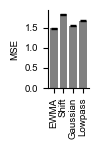

In [11]:
let
    list_type = ["EWMA", "Shift", "Gaussian", "Lowpass"]
    
    u = zeros(4)
    s = zeros(4)
    for i = 1:4
        data_ = filter(x->x<1e9, vcat(map(x->x[:,i], list_cost_array)...))
        u[i] = mean(data_)
        s[i] = sem(data_)
    end
    
    figure(figsize=(1.,1.5))
    bar(0:3, u, yerr=s, capsize=2, color="gray")
    xticks(0:3, list_type, rotation=90)
    # ylim(0,2)
    ylabel("MSE")
    
    fix_plot()
    tight_layout()
    savefig(joinpath(path_fig_root, "smoothing_comparison.pdf"))
    for i = 2:4
        println("Test for $(list_type[i])")
        MannWhitneyUTest(vcat(map(x->x[:,1], list_cost_array)...),
            vcat(map(x->x[:,i], list_cost_array)...)) |> println
    end
end